In [1]:
from bs4 import BeautifulSoup
from datetime import datetime
import requests
from IPython.display import clear_output
import time
import webbrowser
import numpy as np
import unicodedata
import pickle
import pandas as pd
import codecs
import matplotlib.pyplot as plt

#Function to create time list
def ListofTime_generator(StartYear,StartMon,EndYear,EndMon):
    ListofTime = []
    while(StartYear!=EndYear or StartMon!=EndMon):
        ListofTime.append(str(StartYear) + "-" + str(StartMon).zfill(2))
        if StartMon == 12:
            StartYear += 1
            StartMon = 1
        else:
            StartMon += 1
    ListofTime.append(str(EndYear) + "-" + str(EndMon).zfill(2))
    return ListofTime

def HTMLrequest(ListofTime):
    #ListofTime = [] #200812 - 201903
    LinkHeader = "https://www.checkee.info/main.php?dispdate="
    AllPages = {}
    len_month = len(ListofTime)
    start_time = time.time()
    count = 1
    for months in ListofTime:
        clear_output()
        cur_time = time.time()
        print("requesting from " + LinkHeader + months)
        print("Progress: ",count,"/",len_month)
        print("time elapsed:",int(cur_time-start_time),"seconds")
        estimation = (cur_time-start_time)/count*(len_month-count)/60
        print("Estimate Time Left: %5.2f Minutes" % (estimation))
        session = requests.Session()
        page = session.get(LinkHeader + months, headers={'User-Agent': 'Mozilla/5.0'})
        AllPages[months] = page.content.decode("utf-8","ignore")
        count += 1
    return AllPages

#use strtmp for develope
class ApplicationCase():
    def __init__(self, ID):
        self.ID = ID
        self.VisaType = None
        self.VisaEntry = None
        self.Consulate = None
        self.Major = None
        self.CheckDate = None
        self.CompleteDate = None
        self.WaitingDays = None
        self.Comment = None
        self.Status = None

    def DebugPrint(self):
        if self.CompleteDate:
            print("----   This case is completed   ----")
        else:
            print("**** This case is not completed ****")
        print("ID            :",self.ID)
        print("Visa Type     :",self.VisaType)
        print("Visa Entry    :",self.VisaEntry)
        print("Consulate     :",self.Consulate)
        print("Major         :",self.Major)
        print("Status        :",self.Status)
        print("Check Date    :",self.CheckDate)
        print("Complete Date :",self.CompleteDate)
        print("Waiting Days  :",self.WaitingDays)
        print("Comment       :",self.Comment)
    def CasetoList(self):
        table = [self.ID,self.VisaType,self.VisaEntry,self.Consulate,self.Major,self.Status,self.CheckDate,self.CompleteDate,self.WaitingDays,self.Comment]
        return table
    def ComputeWaitingDays(self):
        if self.CompleteDate and self.CheckDate:
            self.WaitingDays = self.CompleteDate-self.CheckDate
        else: 
            return

#The struct of the data is organized in dictionary sorted by Months
#Return a list of applications
def ExtractDatafromHTML(AllPages):
    ApplicationofAll = {}
    for keys in AllPages.keys():
        clear_output()
        print("processing month",keys)
        #convert html page to beautifulsoup object
        pagetmp = AllPages[keys]
        soup = BeautifulSoup(pagetmp, 'html.parser')
        #There are 8 tables in the html
        #find the 6th table and extract it to be further analysised
        table = soup.find_all("table")
        count = 0
        for items in table:
            if count == 6:
                target = items
                break
            count+=1
        #In this table, separated case by case except item 0
        #item 0 contains the header of the table
        #so item 0 is poped in the program
        applications = target.find_all("tr")
        applications.pop(0)
        CasesofMonth = []
        for apps in applications:
            SingleCase = apps.find_all("td")
            SingleCase.pop(0)
            count = 0
            for items in SingleCase:
                #print(str(items)[4:-5])
                if count == 0:
                    AppTmp = ApplicationCase(str(items)[4:-5])
                elif count == 1:
                    AppTmp.VisaType = str(items)[4:-5]
                elif count == 2:
                    AppTmp.VisaEntry = str(items)[4:-5]
                elif count == 3:
                    AppTmp.Consulate = str(items)[4:-5]
                elif count == 4:
                    AppTmp.Major = str(items)[4:-5]
                elif count == 5:
                    AppTmp.Status = str(items)[4:-5]
                elif count == 6:
                    AppTmp.CheckDate = str(items)[4:-5]
                elif count == 7:
                    AppTmp.CompleteDate = str(items)[4:-5]
                elif count == 8:
                    AppTmp.WaitingDays = int(str(items)[4:-5])
                elif count == 9:
                    AppTmp.Comment = str(items)[74:-52]
                count += 1
            CasesofMonth.append(AppTmp)
        ApplicationofAll[keys] = CasesofMonth

    #converting dictionary to list
    APPLICATIONS_OF_ALL = []
    for keys in ApplicationofAll.keys():
        for items in ApplicationofAll[keys]:
            APPLICATIONS_OF_ALL.append(items.CasetoList())
    for items in APPLICATIONS_OF_ALL:
        items[6] = datetime.strptime(items[6], '%Y-%m-%d')
        if items[7] == "0000-00-00":
            items[7] = None
        else:
            items[7] = datetime.strptime(items[7], '%Y-%m-%d')
        if items[-1] == "":
            items[-1] = None
    return APPLICATIONS_OF_ALL

#converting list of applications to pandas data frame
def ListtoPandasFrame(APPLICATIONS_OF_ALL):
    #APPLICATIONS_OF_ALL to pandas data frame
    tabs = ["ID","VisaType","VisaEntry","Consulate","Major","Status","CheckDate","CompleteDate","WaitingDays","Comments"]
    ApplicationFrame = pd.DataFrame(APPLICATIONS_OF_ALL,columns=tabs)
    return ApplicationFrame

In [71]:
#print(ListofTime)

In [3]:
StartYear,StartMon,EndYear,EndMon = 2008,12,2019,6
#flag for processing, if flag==1, download from online and save it to csv
#if flag==2, load data from csv file
flag = 1
if flag == 1:
    ListofTime = ListofTime_generator(StartYear,StartMon,EndYear,EndMon)
    AllPages = HTMLrequest(ListofTime)
    APPLICATIONS_OF_ALL = ExtractDatafromHTML(AllPages)
    ApplicationFrame = ListtoPandasFrame(APPLICATIONS_OF_ALL)
    ApplicationFrame.to_csv("./database/PandasApplicationData.csv", index = False, sep=',', encoding='utf-8')
elif flag == 2:
    ApplicationFrame = pd.read_csv("./database/PandasApplicationData.csv")

processing month 2019-06


In [9]:
#ApplicationFrame.drop(na(subset = ["CompleteDate"]))
FinishedAppsFrame = ApplicationFrame[ApplicationFrame.Status == "Clear"]
LongCheckAppsFrame = FinishedAppsFrame[FinishedAppsFrame.WaitingDays >=60 ]
FAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "F"]
HAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "H"]
JAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "J"]
BAppsFrame = FinishedAppsFrame[FinishedAppsFrame.VisaType.str.slice(stop=1) == "B"]
LongCheckAppsFrame

,ID,VisaType,VisaEntry,Consulate,Major,Status,CheckDate,CompleteDate,WaitingDays,Comments
0,dolong,H4,New,Others,Chemistry,Clear,2008-12-01,2009-03-17,106,None
1,piglet,J2,,BeiJing,CS,Clear,2008-12-01,2009-03-13,102,None
2,Kevin,J1,Renewal,BeiJing,Biochemistry,Clear,2008-12-01,2009-03-17,106,None
3,jzl,H1,Renewal,BeiJing,Materials Science,Clear,2008-12-02,2009-03-19,107,None
4,heartlake,H1,Renewal,BeiJing,Neuroscience,Clear,2008-12-02,2009-03-17,105,None
5,zerocool,H1,Renewal,ShangHai,CS,Clear,2008-12-03,2009-03-19,106,None
6,oldloser,H1,Renewal,BeiJing,EE,Clear,2008-12-03,2009-03-20,107,None
7,sunrising,F1,Renewal,ShangHai,ME,Clear,2008-12-03,2009-03-18,105,None
8,conky_boy,J1,New,ShangHai,condensed matter physics,Clear,2008-12-03,2009-03-18,105,None
9,Technicolor,B2,New,Others,Physics,Clear,2008-12-03,2009-03-18,105,None


In [29]:
LongCheckAppsFrame[()()]

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

In [51]:
test = FinishedAppsFrame[(FinishedAppsFrame.CheckDate>"2018-12")&(FinishedAppsFrame.CheckDate<"2019-01")]
test.count()[0]

662

Text(0.5, 1.0, 'Monthly Long Check number AVG')

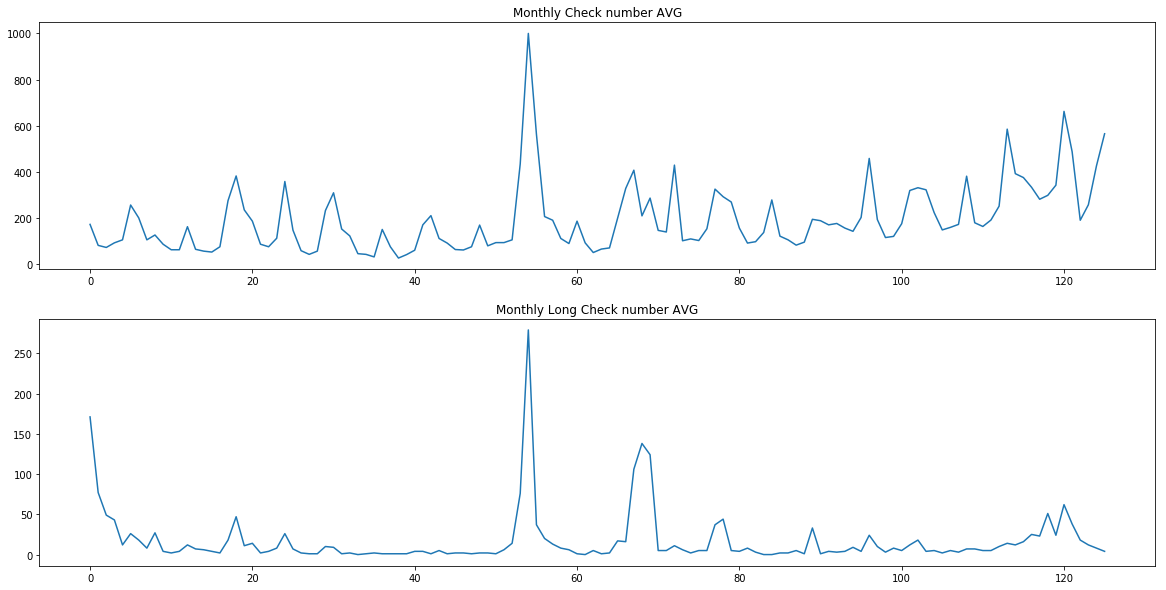

In [95]:
Checknums = []
longchecknums = []
ListofTime = ListofTime_generator(StartYear,StartMon,EndYear,EndMon)
buf = ListofTime[:-1]
timeaxis = []
for items in buf:
    timeaxis.append(int(items[0:4])*100+int(items[5:7]))

#print(ListofTime)
#print(timeaxis)

checkavgtime = []
longcheckavgtime = []

for i in range(len(ListofTime)-1):
    checkbuf = FinishedAppsFrame[(FinishedAppsFrame.CheckDate>ListofTime[i])&(FinishedAppsFrame.CheckDate<ListofTime[i+1])]
    longcheckbuf = LongCheckAppsFrame[(LongCheckAppsFrame.CheckDate>ListofTime[i])&(LongCheckAppsFrame.CheckDate<ListofTime[i+1])]
    Checknums.append(checkbuf.count()[0])
    longchecknums.append(longcheckbuf.count()[0])
    
plt.figure(figsize=(20,10))
ax1 = plt.subplot(2,1,1)
plt.plot(Checknums)
#plt.xticks(timeaxis, timeaxis, rotation='vertical')

ax2 = plt.subplot(2,1,2)
plt.plot(longchecknums)
#plt.xticks(timeaxis, timeaxis, rotation='vertical')

ax1.set_title('Monthly Check number AVG')
ax2.set_title('Monthly Long Check number AVG')





In [94]:
print(timeaxis)

[200812, 200901, 200902, 200903, 200904, 200905, 200906, 200907, 200908, 200909, 200910, 200911, 200912, 201001, 201002, 201003, 201004, 201005, 201006, 201007, 201008, 201009, 201010, 201011, 201012, 201101, 201102, 201103, 201104, 201105, 201106, 201107, 201108, 201109, 201110, 201111, 201112, 201201, 201202, 201203, 201204, 201205, 201206, 201207, 201208, 201209, 201210, 201211, 201212, 201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308, 201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412, 201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,

In [92]:
test = "2015-03"
year = int(test[0:4])
mon = int(test[5:7])

print(year,mon)

2015 3
